In [6]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [20]:
import pickle
from itertools import permutations
from collections import Counter
import numpy as np
from scipy.stats import pearsonr, t
from scipy.stats.mstats import pearsonr as nanpeasonr
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tnrange, tqdm_notebook

In [8]:
import cvtk.variant_files as vf

In [9]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [10]:
plt.style.use('./buffalo.mplstyle')

In [11]:
VCF_FILE = '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz'

sf = vf.AD_DP_VCFFile(VCF_FILE)
gi = sf.build_gintervals()

reading file '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz'...
file '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz' loaded.
total time to load VCF file: 0.19136969645818075 mins.


### Parse the CSV INFO field

In [12]:
cols = ['CHROM','POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 
        'FORMART', 'FL1', 'FL2', 'GA', 'SC', 'NC', 'ME1', 'ME2', 'PA_7_2009',
        'PA_11_2009', 'PA_7_2010', 'PA_11_2010', 'PA_7_2011', 'PA_10_2011', 'PA_11_2011']
d = pd.read_csv(VCF_FILE, delimiter='\t', comment='#', names=cols, index_col=False)

In [13]:
def parse_info(x):
    rows = []
    for line in x:
        rows.append(dict([tuple(x.split('=')) for x in line.split(';')]))
    return rows

rows = parse_info(d['INFO'].values)
# original seasonal p-values
SP = np.array([float(x['SP']) for x in rows])

In [14]:
depths = sf.mat.sum(axis=2)

In [15]:
diploids = np.array([39, 48, 51, 48, 46, 86, 75, 55, 74, 116, 33, 75, 47, 50])
nchr = 2*diploids

## GLM Analysis of Seasonal Data

We extract the sample months (for Fall / Spring labels) and indices from the original sample names:

In [16]:
indices, samples = zip(*[(i, x.split('_')[1]) for i, x in enumerate(sf.samples) if x.startswith('PA_')])
indices, samples = np.array(indices)[:-1], np.array(samples)[:-1]
print(dict(zip(indices, samples)))

{7: '7', 8: '11', 9: '7', 10: '11', 11: '7', 12: '10'}


In [17]:
def Neff(depth, nchr):
    return np.floor((nchr * depth - 1) / (nchr + depth))

In [18]:
def seasonal_model(freqs, model_matrix, Neff, constant=True):
    if constant:
        model_matrix = sm.add_constant(model_matrix)
    m = sm.GLM(freqs, model_matrix, var_weights=Neff, family=sm.families.Binomial())
    return m

# For spring, we use 1, Fall 0
seasonal_model_matrix = np.array([{'7': 1, '11': 0, '10':0}[x] for x in samples], dtype='int64')
seasonal_model_matrix

array([1, 0, 1, 0, 1, 0])

In [13]:
def apply_model(mat, model, model_matrix, nchr, progress=True, permute=False, **kwargs):
    depth = mat.sum(axis=2)
    freqs = mat[:, :, 0] / depth    
    Neff_weights = Neff(depth, nchr)
    nloci = mat.shape[0]
    models = []
    #nloci = 10000  # for testing
    loci_range = range(nloci) if not progress else tnrange(nloci)
    for l in loci_range:
        #import pdb; pdb.set_trace()
        if permute:
            model_matrix = np.random.permutation(model_matrix)
        m = model(freqs[l, ...], model_matrix=model_matrix, Neff=Neff_weights[l, ...], **kwargs)
        models.append(m.fit())
    return models

In [14]:
CACHE_GLMFITS = '../data/bergland_et_al_2014/bergland_glmfits_per_locus.pkl'
FORCE = False

if FORCE or not os.path.exists(CACHE_GLMFITS):
    loci_models = apply_model(sf.mat[:, indices, :], seasonal_model, seasonal_model_matrix, nchr[indices], constant=True)
    with open(CACHE_GLMFITS, 'wb') as f:
        pickle.dump(loci_models, f)
else:
     with open(CACHE_GLMFITS, 'rb') as f:
        loci_models = pickle.load(f)

In [ ]:
pvals = np.array([f.pvalues[1] for f in loci_models])

Save the p-values from the original study, and our re-analysis p-values.

In [18]:
pval_comparison = pd.DataFrame(dict(bergland_pvals=SP, our_pvals=pvals))
pval_comparison.to_feather('../data/bergland_et_al_2014/bergland_pvalue_comparison.feather')
pval_comparison.to_csv('../data/bergland_et_al_2014/bergland_pvalue_comparison.csv')

In [84]:
pval_comparison = pd.read_feather('../data/bergland_et_al_2014/bergland_pvalue_comparison.feather')
pvals = pval_comparison['bergland_pvals'].values

## Permutation Analysis

## Permuting Seasons per Locus

In [19]:
NREPS = 100
permutations = seasonal_model

In [20]:
CACHE_PERMUTATION = '../data/bergland_et_al_2014/bergland_permutation_per_locus.pkl'

if FORCE or not os.path.exists(CACHE_PERMUTATION):
    permuted_loci_models = []

    for rep in tnrange(NREPS):
        res = apply_model(sf.mat[:, indices, :], seasonal_model, seasonal_model_matrix,
                           nchr=nchr[indices], permute=True, constant=True)
        permuted_loci_models.append(res)
    with open(CACHE_PERMUTATION, 'wb') as f:
        pickle.dump(permuted_loci_models, f)
else:
     with open(CACHE_PERMUTATION, 'rb') as f:
        permuted_loci_models = pickle.load(f)

In [24]:
locus_permuted_pvals = np.array([[f.pvalues[1] for f in res] for res in permuted_loci_models])

In [26]:
with open('../data/bergland_et_al_2014/locus_level_permutation_pvalues.npy', 'wb') as f:
    np.save(f, locus_permuted_pvals)

### Permuting Seasons Once Per Run

We can randomly permute each a large number of times, however there are not many unique permutations. So instead, we take the unique number of permutations, and weight the resulting histogram by their weights.

In [25]:
perms = list(permutations(seasonal_model_matrix.tolist()))
print(f"total number of permutations of indices: {len(perms)}")
print(f"weights of permutations: ")
Counter(perms)

total number of permutations of indices: 720
weights of permutations: 


Counter({(1, 0, 1, 0, 1, 0): 36,
         (1, 0, 1, 0, 0, 1): 36,
         (1, 0, 1, 1, 0, 0): 36,
         (1, 0, 0, 1, 1, 0): 36,
         (1, 0, 0, 1, 0, 1): 36,
         (1, 0, 0, 0, 1, 1): 36,
         (1, 1, 0, 0, 1, 0): 36,
         (1, 1, 0, 0, 0, 1): 36,
         (1, 1, 0, 1, 0, 0): 36,
         (1, 1, 1, 0, 0, 0): 36,
         (0, 1, 1, 0, 1, 0): 36,
         (0, 1, 1, 0, 0, 1): 36,
         (0, 1, 1, 1, 0, 0): 36,
         (0, 1, 0, 1, 1, 0): 36,
         (0, 1, 0, 1, 0, 1): 36,
         (0, 1, 0, 0, 1, 1): 36,
         (0, 0, 1, 1, 1, 0): 36,
         (0, 0, 1, 1, 0, 1): 36,
         (0, 0, 1, 0, 1, 1): 36,
         (0, 0, 0, 1, 1, 1): 36})

Thus all permutations have the same weight. Since these permutations are symmetric around 0 and 1 (e.g. `0 0 0 1 1 1` and `1 1 1 0 0 0` have the same p-value), we can ignore half of these:

In [52]:
# number of unique permutations 
unique_perms_str = set(['-'.join(map(str, x)) for x in perms])
unique_perms = sorted([tuple(map(int, x.split('-'))) for x in unique_perms_str])
print(f"number of permutations: {len(unique_perms)}")

number of permutations: 20


Since the p-value of the slope of GLM's dummy variable is invariant with respect to coding 0 or 1, we take only half these permutations, and ignore their symmetric complements:

In [64]:
unique_sym_perms = unique_perms[:10]
umique_sym_perms_complement = [tuple([int(not i) for i in x]) for x in unique_sym_perms]
assert(sorted(unique_perms) == sorted(unique_sym_perms + umique_sym_perms_complement))
print(f"number of unique permutations, ignoring symmetries: {len(unique_sym_perms)}")
unique_sym_perms

number of unique permutations, ignoring symmetries: 10


[(0, 0, 0, 1, 1, 1),
 (0, 0, 1, 0, 1, 1),
 (0, 0, 1, 1, 0, 1),
 (0, 0, 1, 1, 1, 0),
 (0, 1, 0, 0, 1, 1),
 (0, 1, 0, 1, 0, 1),
 (0, 1, 0, 1, 1, 0),
 (0, 1, 1, 0, 0, 1),
 (0, 1, 1, 0, 1, 0),
 (0, 1, 1, 1, 0, 0)]

In [73]:
#unique_sym_perms_sans_seasonal = [x for x in unique_sym_perms if x != (0, 1, 0, 1, 0, 1)]

CACHE_PERMUTATION_REP = '../data/bergland_et_al_2014/bergland_permutation_per_rep.pkl'
if FORCE or not os.path.exists(CACHE_PERMUTATION_REP):
    permuted_rep_models = []

    for permutation in tqdm_notebook(unique_sym_perms):
        print(f"running model on permutation {permutation}")
        res = apply_model(sf.mat[:, indices, :], seasonal_model, np.array(permutation, dtype='int64'),
                           nchr=nchr[indices], permute=False, constant=True)
        permuted_rep_models.append(res)
else:
     with open(CACHE_PERMUTATION_REPe, 'rb') as f:
        permuted_rep_models = pickle.load(f)

running model on permutation (0, 0, 0, 1, 1, 1)


running model on permutation (0, 0, 1, 0, 1, 1)


running model on permutation (0, 0, 1, 1, 0, 1)


running model on permutation (0, 0, 1, 1, 1, 0)


running model on permutation (0, 1, 0, 0, 1, 1)


running model on permutation (0, 1, 0, 1, 0, 1)


running model on permutation (0, 1, 0, 1, 1, 0)


running model on permutation (0, 1, 1, 0, 0, 1)


running model on permutation (0, 1, 1, 0, 1, 0)


running model on permutation (0, 1, 1, 1, 0, 0)


In [76]:
rep_permuted_pvals = np.array([[f.pvalues[1] for f in res] for res in permuted_rep_models])

In [77]:
with open('../data/bergland_et_al_2014/rep_level_permutation_pvalues.npy', 'wb') as f:
    np.save(f, rep_permuted_pvals)

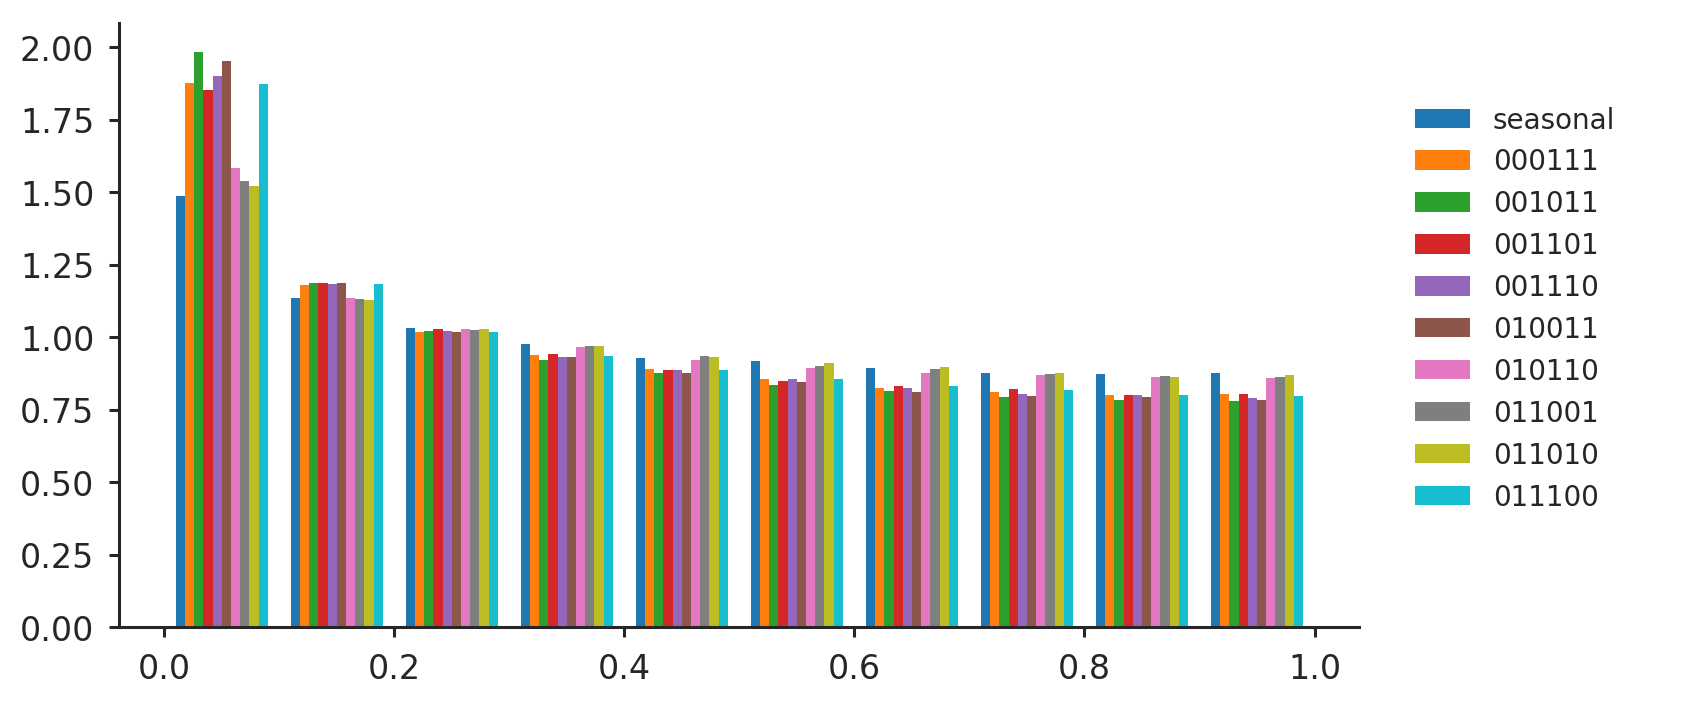

In [116]:
# we delete the fifth permutation, which is seasonal one.
labels = tuple(['seasonal'] + [''.join(map(str, x)) for x in np.delete(np.array(unique_sym_perms), 5, axis=0)])
plt.hist(np.hstack((pvals.reshape(-1, 1), np.delete(rep_permuted_pvals.T, 5, axis=1))),
         density=True, label=labels)
plt.legend(loc=(1, 0.1))